In [1]:
import re
import os
import joblib
import numpy as np
import pandas as pd

from sklearn.decomposition import PCA
from sklearn.pipeline import make_pipeline
from sklearn.cluster import MiniBatchKMeans
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.linear_model import LinearRegression, Ridge, Lasso, LogisticRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, accuracy_score, confusion_matrix


In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
from typing import List, Tuple
from scipy import stats

def plot_correlation_matrix(
        data: pd.DataFrame,
        ignore_cols: List[str] = [],
        method: str = "Spearman",
        **kwargs) -> Tuple[plt.Figure, plt.Axes]:
    """
    Grafica la matriz de correlaciones de un dataset como un heatmap.

    Parameters
    ----------
    data: Un dataframe.
    ignore_cols: Columnas a ignorar para el calculo.
    method: Metodo a usar para calcular las correlaciones. Puede ser
        Pearson o Spearman.
    kwargs: Argumentos adicionales para plt.subplots

    Returns
    -------
    Fig, ax de la figura creada.
    """
    ignore_cols = ignore_cols + [
        c for c in data.columns
        if data.dtypes[c] == "object" and c not in ignore_cols
    ]
    df = data.drop(columns=ignore_cols) if len(ignore_cols) > 0 else data

    if method == "Spearman":
        corr_matrix = stats.spearmanr(df, axis=0).correlation
    elif method == "Pearson":
        corr_matrix = np.corrcoef(df, rowvar=False)
    else:
        raise ValueError(
            "Invalid correlation method! Methods supported: Pearson, Spearman"
        )

    hmap = pd.DataFrame(corr_matrix)
    hmap.columns = df.columns
    hmap.index = df.columns

    fig, ax = plt.subplots(1, 1, **kwargs)
    sns.heatmap(hmap, ax=ax, cmap="coolwarm", vmin=-1, vmax=1)
    return fig, ax


def quick_histogram(
        data: pd.DataFrame,
        column: str,
        save_to: str = None,
        bins: int = 35) -> Tuple[plt.Figure, plt.Axes]:
    """
    Grafica un histograma de la variable dada que muestra la media y la
    mediana.

    Parameters
    ----------
    data: Un dataframe.
    column: Columna con variable a graficar.
    save_to: Ruta en que se guardará la imagen (opcional).
    bins: Número de barras del histograma.

    Returns
    -------
    El Figure y el Axes de la figura creada.
    """
    fig, ax = plt.subplots()
    ax.set_title("Histogram of: " + column)
    data[column].plot.hist(bins=bins, ax=ax, edgecolor='k', alpha=0.75)

    mean_val = data[column].mean()
    median_val = data[column].median()
    ax.axvline(mean_val, label="mean: %0.2f" % mean_val, c='k')
    ax.axvline(median_val, label="median: %0.2f" % median_val, c='r')
    ax.legend()

    if save_to is not None:
        fig.savefig(fname=save_to)

    return fig, ax

def plot_pca(
        data: np.ndarray,
        labels: np.ndarray,
        interval: int = 1,
        seed: int = 987,
        **kwargs) -> Tuple[plt.Figure, plt.Axes]:
    """
    Applies PCA to the data and plots the results in 2D.
    """

    pca_vecs = PCA(n_components=2).fit_transform(
        StandardScaler().fit_transform(data)
    )

    np.random.seed(seed)
    shuffle_ind = np.arange(0, pca_vecs.shape[0])
    np.random.shuffle(shuffle_ind)

    fig, ax = plt.subplots(**kwargs)
    ax.grid()

    xs = pca_vecs[shuffle_ind, 0]
    ys = pca_vecs[shuffle_ind, 1]

    sns.scatterplot(
        x=xs[::interval],
        y=ys[::interval],
        hue=labels[shuffle_ind][::interval],
        ax=ax
    )
    
    return fig, ax

# First Exploration
This notebook contains a first (brief) exploration of the stackexchange data (including our hand-engineered features)
along with some first attempts at a predictive model.

In [3]:
datapath = "Dataset"

df = pd.concat([
    pd.read_csv(os.path.join(datapath, p))
    for p in os.listdir(datapath)
    if p.endswith(".csv")
]).reset_index(drop=True)


median_score = df.score.median()
print("Score median: %0.4f" % median_score)
df["target"] = (df["score"] >= median_score).astype("uint8")

print(df.shape)

df.head()

Score median: 2.0000
(733178, 23)


,folder,id,body,title,tags,n_views,time,n_answers,score,time_til_first_answer,...,n_tags,num_question_marks,wh_word_count,sentence_count,word_count,example_count,n_linebreaks,title_word_count,title_question_marks,target
0,Data/android.stackexchange.com,1,This is a common question by those who have ju...,I've rooted my phone. Now what? What do I ga...,<rooting><root-access>,477272,2010-09-13 19:16:26.763,3,308,0.103480,...,2,2,3,4,29,0,1,13,2,1
1,Data/android.stackexchange.com,2,I have a Google Nexus One with Android 2.2. I ...,"I installed another SMS application, now I get...",<2.2-froyo><sms><notifications><handcent-sms>,1233,2010-09-13 19:17:17.917,3,11,0.034801,...,4,1,2,4,36,0,1,10,0,1
2,Data/android.stackexchange.com,5,I have a Motorola DROID v1 that is running Fro...,Moto Droid v1 disabling primary Wireless AP,<2.2-froyo>,312,2010-09-13 19:19:35.360,1,5,4112.699605,...,1,1,3,6,101,0,2,7,0,1
3,Data/android.stackexchange.com,8,I would like to send two contacts (name+phone ...,How do I send a contact via SMS?,<contacts><sms>,50115,2010-09-13 19:21:03.273,12,10,0.120577,...,2,1,1,4,49,0,3,8,1,1
4,Data/android.stackexchange.com,9,Does one really need to install a task manager...,Do I really need to install a task manager?,<task-management>,20836,2010-09-13 19:21:10.473,7,95,0.049335,...,1,1,0,2,25,0,1,9,1,1


In [4]:
for i in df.index[:4]:
    row = df.loc[i]
    for i in row.index:
        print(i, " -- ", row[i])
    
    print("=" * 50)

folder  --  Data/android.stackexchange.com
id  --  1
body  --  This is a common question by those who have just rooted their phones.  What apps, ROMs, benefits, etc. do I get from rooting?  What should I be doing now?

title  --  I've rooted my phone.  Now what?  What do I gain from rooting?
tags  --  <rooting><root-access>
n_views  --  477272
time  --  2010-09-13 19:16:26.763
n_answers  --  3
score  --  308
time_til_first_answer  --  0.10347972222222222
y  --  8958.276849731697
n_lists  --  0
n_links  --  0
n_tags  --  2
num_question_marks  --  2
wh_word_count  --  3
sentence_count  --  4
word_count  --  29
example_count  --  0
n_linebreaks  --  1
title_word_count  --  13
title_question_marks  --  2
target  --  1
folder  --  Data/android.stackexchange.com
id  --  2
body  --  I have a Google Nexus One with Android 2.2. I didn't like the default SMS-application so I installed Handcent-SMS. Now when I get an SMS, I get notified twice. How can I fix this?

title  --  I installed another S

## Variable Histograms

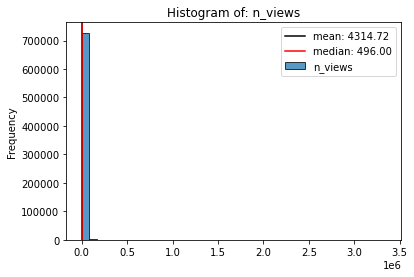

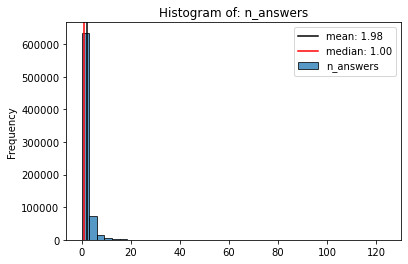

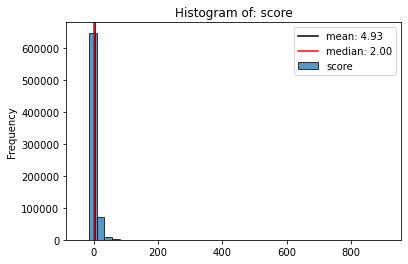

BAD time_til_first_answer


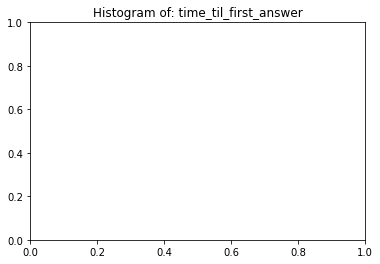

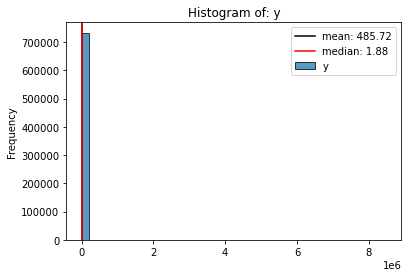

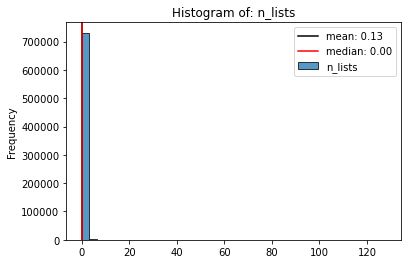

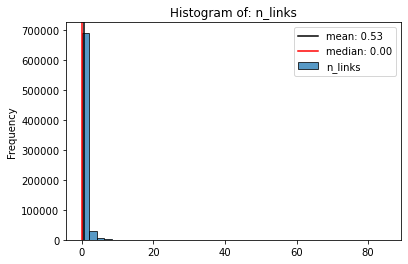

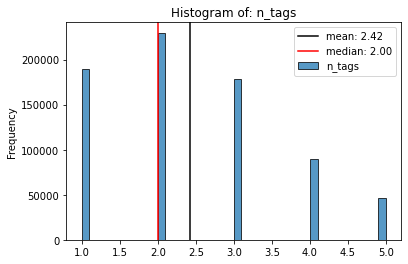

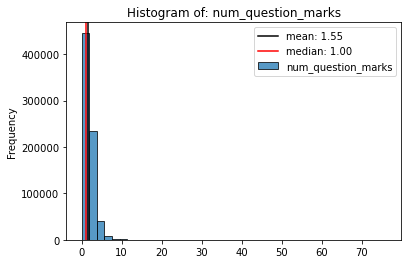

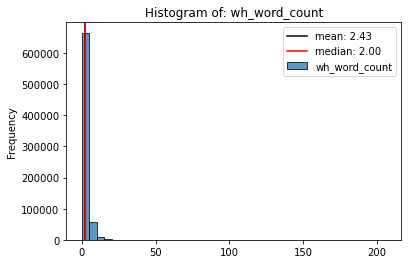

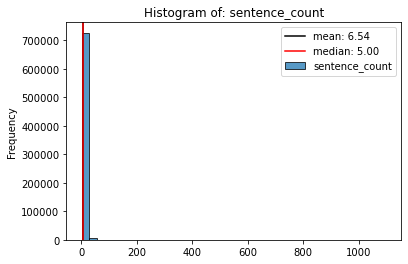

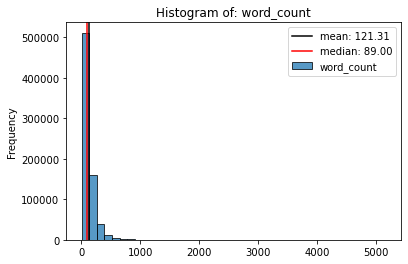

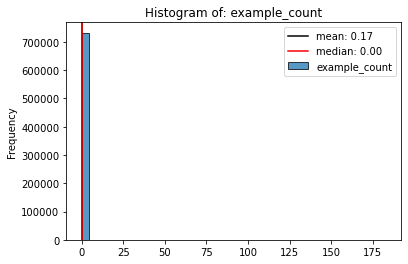

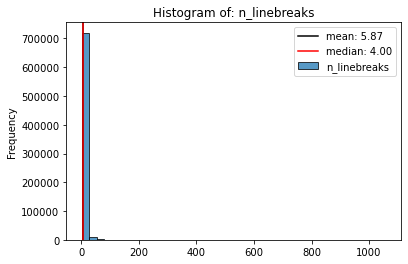

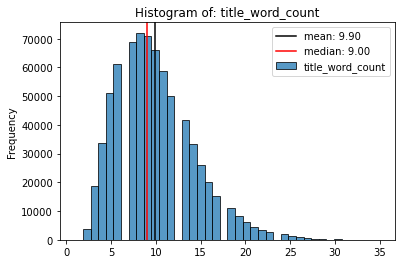

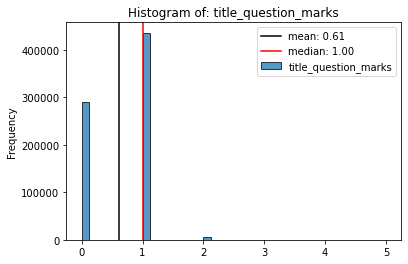

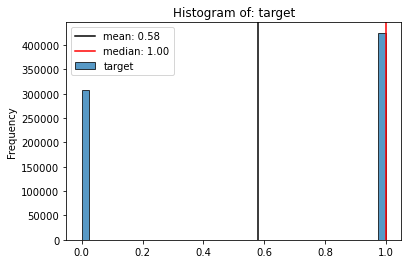

In [5]:
for c in df.columns:
    if c == "id" or df.dtypes[c] == "object":
        continue
    
    try:
        fig, ax = quick_histogram(df, c, bins=40)
        plt.show()
    except:
        print("BAD", c)

In [6]:
df.y.min(), df.y.max(), df.y.mean(), df.y.median()

(0.0, 8481600.0, 485.72422872199263, 1.8800907450131148)

## Comment on histograms
After a first glance at these histograms we can see that many of our hand-engineered features are concentrated around 0 but many
of them have very long tails with extreme outliers. This is particularly concerning when it comes to our response variable. One
possible way to fix this would be to use logarithmic trainsforms. First, however, we will study the variables further and then try some 
simple models.

In [7]:
FEATURES = [
    "wh_word_count",
    "sentence_count",
    "word_count",
    "example_count",
    "n_linebreaks",
    "title_word_count",
    "title_question_marks",
    "n_links",
    "n_tags",
    "num_question_marks",
    "n_lists"
]

quantiles = [0.01, 0.25, 0.5, 0.75, 0.99, 0.995]
feature_qts = {}

for f in FEATURES:
    qts = np.quantile(df[f], quantiles)
    print("Feature: %s" % f)
    print(
        "Quantiles:",
        ", ".join([
            f"{q}: {v}"
            for q, v in zip(quantiles, qts)
        ])
    )
    print("Feature max: %.4f" % df[f].max())
    print("=" * 40 + "\n")
    
    # Store 99.5% quantile
    feature_qts[f] = qts[-1]


Feature: wh_word_count
Quantiles: 0.01: 0.0, 0.25: 1.0, 0.5: 2.0, 0.75: 3.0, 0.99: 12.0, 0.995: 14.0
Feature max: 206.0000

Feature: sentence_count
Quantiles: 0.01: 1.0, 0.25: 3.0, 0.5: 5.0, 0.75: 8.0, 0.99: 28.0, 0.995: 34.0
Feature max: 1099.0000

Feature: word_count
Quantiles: 0.01: 15.0, 0.25: 53.0, 0.5: 89.0, 0.75: 150.0, 0.99: 561.0, 0.995: 697.0
Feature max: 5176.0000

Feature: example_count
Quantiles: 0.01: 0.0, 0.25: 0.0, 0.5: 0.0, 0.75: 0.0, 0.99: 2.0, 0.995: 3.0
Feature max: 183.0000

Feature: n_linebreaks
Quantiles: 0.01: 1.0, 0.25: 2.0, 0.5: 4.0, 0.75: 7.0, 0.99: 36.0, 0.995: 49.0
Feature max: 1059.0000

Feature: title_word_count
Quantiles: 0.01: 3.0, 0.25: 7.0, 0.5: 9.0, 0.75: 12.0, 0.99: 23.0, 0.995: 24.0
Feature max: 35.0000

Feature: title_question_marks
Quantiles: 0.01: 0.0, 0.25: 0.0, 0.5: 1.0, 0.75: 1.0, 0.99: 1.0, 0.995: 2.0
Feature max: 5.0000

Feature: n_links
Quantiles: 0.01: 0.0, 0.25: 0.0, 0.5: 0.0, 0.75: 1.0, 0.99: 5.0, 0.995: 7.0
Feature max: 85.0000

Featur

# Quantiles Exploration
As we suspected, from comparing some quantiles and the maximum of each feature, we can see that although most values of each feature are fairly concentrated close to 0, many features have a few extreme outliers that will have to be taken into account.

Original Size: 733178
Filtered Size: 714371


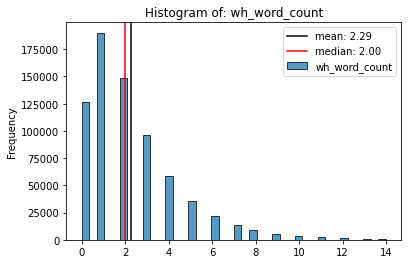

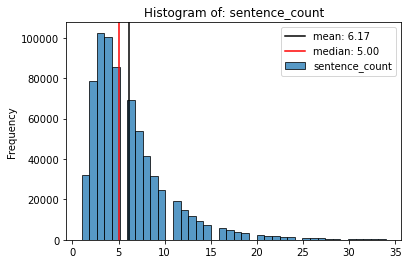

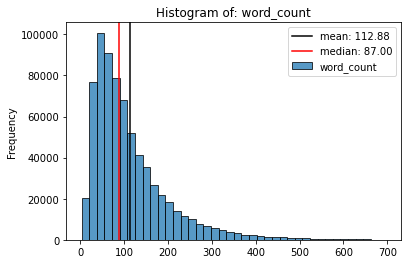

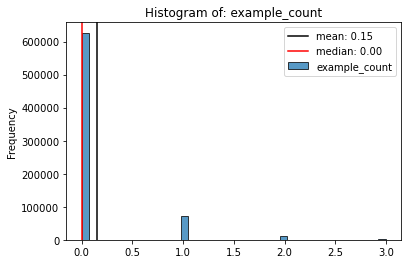

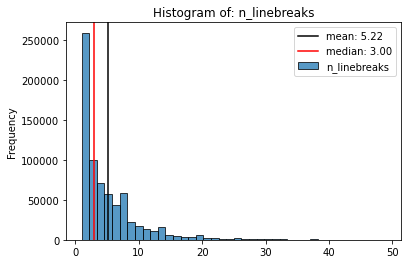

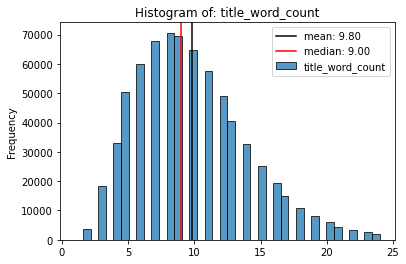

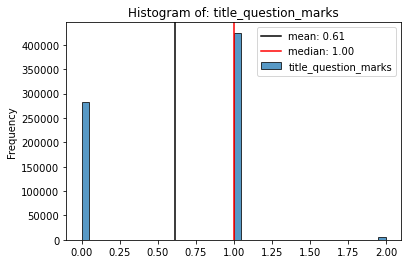

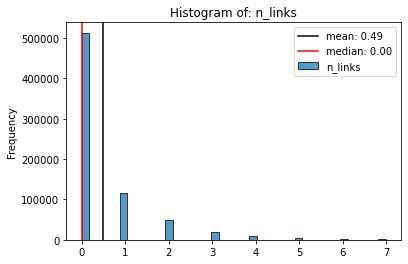

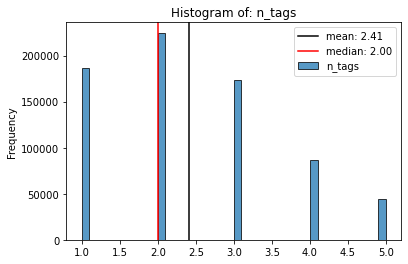

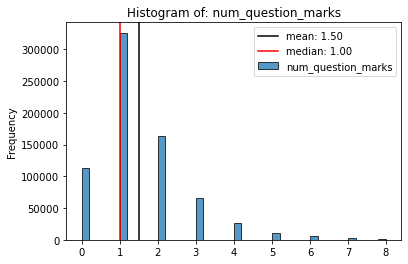

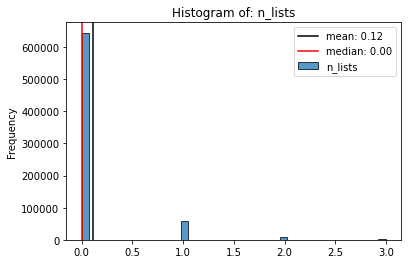

In [8]:
# Remove univariate outliers
df_filtered = df.copy()
for k, v in feature_qts.items():
    df_filtered = df_filtered.loc[df_filtered[k] <= v]

print("Original Size: %d\nFiltered Size: %d" % (df.shape[0], df_filtered.shape[0]))


for c in FEATURES:
    if df_filtered.dtypes[c] == "object":
        continue
    
    try:
        fig, ax = quick_histogram(
            df_filtered,
            c,
            f"images/histogram_{c}.png",
            bins=40
        )
        plt.show()
    except:
        print("BAD", c)

# Filtered Histograms Review
After filtering the extreme univariate outliers, the histograms of the features can be seen more clearly and appear much more stable. The features seem to follow a distribution with a peak near zero that then trails off, which could perhaps be turned into a normal-looking distribution with a logarithmic transform.

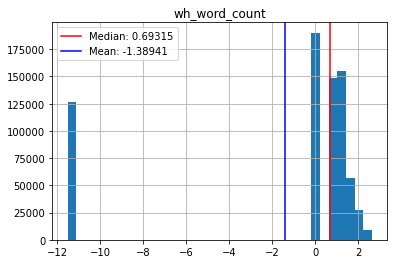

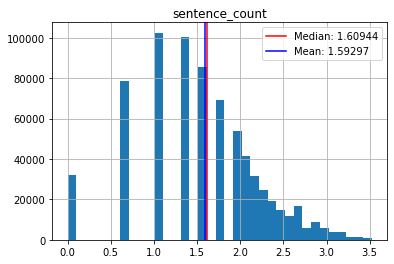

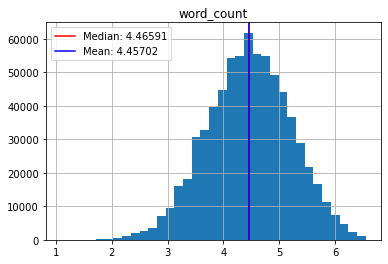

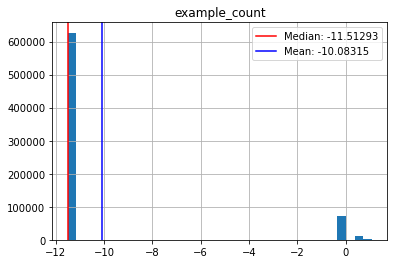

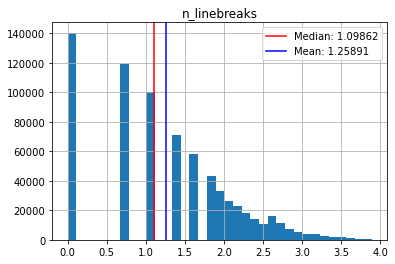

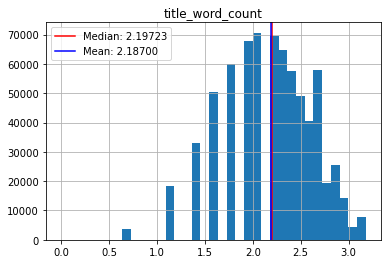

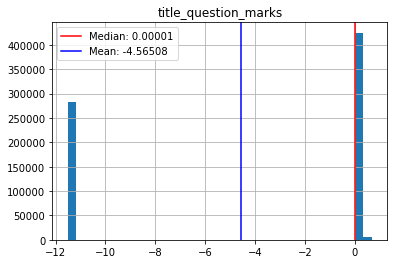

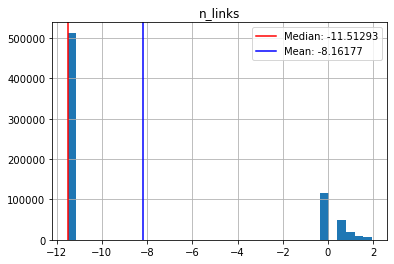

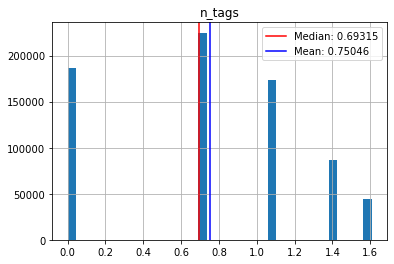

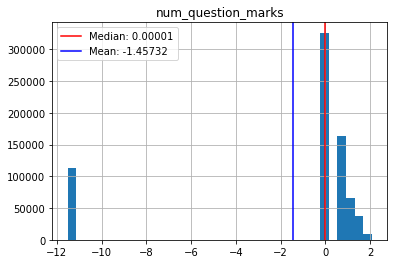

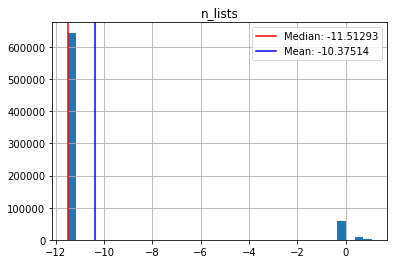

In [9]:
# Epsilon value for stability when computing logs
epsilon = 1e-5


for c in FEATURES:
    if df_filtered.dtypes[c] == "object":
        continue
    
    try:
        fig, ax = plt.subplots()
        vec = np.log(df_filtered[c] + epsilon)
        vec.dropna().hist(ax=ax, bins=35)
        ax.set_title(c)
        medianval = vec.median()
        ax.axvline(medianval, color="red", label=f"Median: {medianval:0.5f}")

        meanval = vec.mean()
        ax.axvline(meanval, color="blue", label=f"Mean: {meanval:0.5f}")
        ax.legend()
        fig.savefig(f"images/log_histogram_{c}.png")
        plt.show()
    except:
        print("BAD", c)

# Log vars
While not all variables have a nicer distribution after applying the log transform, the `word_count`, `title_word_count`, and `sentence_count` variables seem to have a distribution much closer to normal now. This could be useful for training linear models later on.

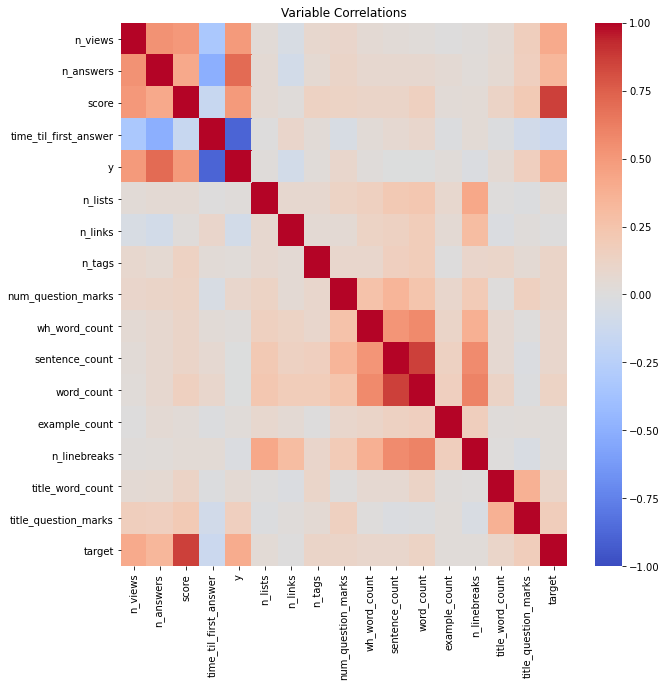

In [10]:
fig, ax = plot_correlation_matrix(df_filtered, figsize=(10, 10), ignore_cols=["id"])
ax.set_title("Variable Correlations")
plt.savefig("images/correlations.png")
plt.show()

# Correlations
From the correlation matrix we can see that there is no serious correlation between our hand-engineered features. There is some correlation between word and sentence count, but not much aside from that. The variables for score, number of answers and number of views do have more significant correlations between them, but this does not affect predictive models as these variables cannot be used as features.

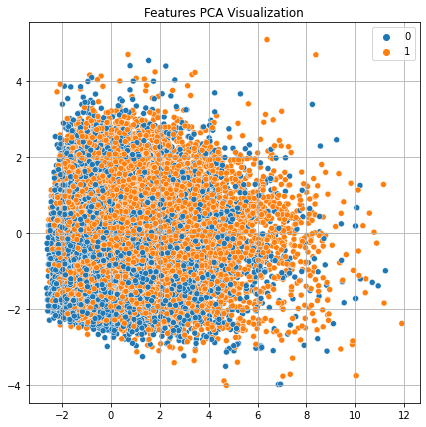

In [11]:
fig, ax = plot_pca(
    df_filtered[FEATURES].values,
    df_filtered["target"].values,
    interval=20,
    figsize=(7, 7)
)

ax.set_title("Features PCA Visualization")
fig.savefig("images/pca_features.png")

plt.show()

# Visualization PCA
From this first visualization of the data using PCA we can see that although there is no clear clustering by label in this projection. However, there does seem to be a slightly higher concentration of 0-labeled points towards the point of the "cone", while 1-labels appear to be more prevalent further from this point. We will later see if a Logistic Regression classifier captures this pattern.

In [12]:
print(df.columns)

Index(['folder', 'id', 'body', 'title', 'tags', 'n_views', 'time', 'n_answers',
       'score', 'time_til_first_answer', 'y', 'n_lists', 'n_links', 'n_tags',
       'num_question_marks', 'wh_word_count', 'sentence_count', 'word_count',
       'example_count', 'n_linebreaks', 'title_word_count',
       'title_question_marks', 'target'],
      dtype='object')


In [13]:
x = df[FEATURES]
y = df["y"]

# y = np.log10(1 + df.y)

print(y.head())
x.head()

0     8958.276850
1     1034.457987
2        0.001459
3     1094.736648
4    13621.084755
Name: y, dtype: float64


,wh_word_count,sentence_count,word_count,example_count,n_linebreaks,title_word_count,title_question_marks,n_links,n_tags,num_question_marks,n_lists
0,3,4,29,0,1,13,2,0,2,2,0
1,2,4,36,0,1,10,0,0,4,1,0
2,3,6,101,0,2,7,0,0,1,1,0
3,1,4,49,0,3,8,1,0,2,1,0
4,0,2,25,0,1,9,1,0,1,1,0


In [14]:
np.random.seed(852)
xtrain, xtest, ytrain, ytest = train_test_split(x, y, test_size=0.25)

print(xtrain.shape, xtest.shape)
print(ytrain.shape, ytest.shape)


pipe = make_pipeline(StandardScaler(), Lasso(alpha=7.5), verbose=True)

pipe.fit(xtrain, ytrain)

(549883, 11) (183295, 11)
(549883,) (183295,)
[Pipeline] .... (step 1 of 2) Processing standardscaler, total=   0.1s
[Pipeline] ............. (step 2 of 2) Processing lasso, total=   0.1s


Pipeline(steps=[('standardscaler', StandardScaler()),
                ('lasso', Lasso(alpha=7.5))],
         verbose=True)

In [15]:
print("Ytrain Variance:")
print(np.var(ytrain))

print("Ytest Variance:")
print(np.var(ytest))

train_pred = pipe.predict(xtrain)

train_mae = mean_absolute_error(y_true=ytrain, y_pred=train_pred)
train_mse = mean_squared_error(y_true=ytrain, y_pred=train_pred)

print("Train set performance:")
print("MSE: ", train_mse)
print("MAE: ", train_mae)

test_pred = pipe.predict(xtest)

test_mae = mean_absolute_error(y_true=ytest, y_pred=test_pred)
test_mse = mean_squared_error(y_true=ytest, y_pred=test_pred)

print("Test set performance:")
print("MSE: ", test_mse)
print("MAE: ", test_mae)

Ytrain Variance:
337596526.9849691
Ytest Variance:
1424759289.6221187
Train set performance:
MSE:  337518779.2149948
MAE:  845.1919681380458
Test set performance:
MSE:  1424635320.2976515
MAE:  968.2957856070424


In [16]:
print("Train MAE for constant model:")
print(np.mean(np.abs(ytrain - np.median(ytrain))))

print("Test MAE for constant model:")
print(np.mean(np.abs(ytest - np.median(ytrain))))

coeff = pd.DataFrame({
    "variable": x.columns,
    "coefficient": pipe[1].coef_
}).sort_values(by="coefficient")

coeff

Train MAE for constant model:
454.0061264502857
Test MAE for constant model:
579.3774680557675


,variable,coefficient
2,word_count,-132.907318
9,num_question_marks,-52.716089
1,sentence_count,-24.900080
4,n_linebreaks,-12.584839
5,title_word_count,-5.411280
3,example_count,-0.000000
10,n_lists,11.009653
7,n_links,87.983593
8,n_tags,127.182473
0,wh_word_count,139.119172


## Lasso model review
Our first model (Lasso) leaves a lot to wish for when it comes to performance (it performs even worse than a constant model wrt MAE), which
points to the fact that we still have a very basic set of features without really diving deep into the text. Perhaps our response
variable could also use some work.

In [17]:
x = df[FEATURES]
y = df["target"]
print(np.mean(y))

# y = np.log10(1 + df.y)

np.random.seed(852)
xtrain, xtest, ytrain, ytest = train_test_split(x, y, test_size=0.25)

print(xtrain.shape, xtest.shape)
print(ytrain.shape, ytest.shape)


pipe = make_pipeline(StandardScaler(), LogisticRegression(class_weight="balanced"), verbose=True)

pipe.fit(xtrain, ytrain)

0.5802888248147108
(549883, 11) (183295, 11)
(549883,) (183295,)
[Pipeline] .... (step 1 of 2) Processing standardscaler, total=   0.1s
[Pipeline]  (step 2 of 2) Processing logisticregression, total=   0.5s


Pipeline(steps=[('standardscaler', StandardScaler()),
                ('logisticregression',
                 LogisticRegression(class_weight='balanced'))],
         verbose=True)

In [18]:
train_pred = pipe.predict(xtrain)

train_acc = accuracy_score(y_true=ytrain, y_pred=train_pred)
train_mat = confusion_matrix(y_true=ytrain, y_pred=train_pred)

print("Train set performance:")
print("Accuracy: ", train_acc)
print("Confusion matrix: \n", train_mat)
print()

test_pred = pipe.predict(xtest)

test_acc = accuracy_score(y_true=ytest, y_pred=test_pred)
test_mat = confusion_matrix(y_true=ytest, y_pred=test_pred)

print("Test set performance:")
print("Accuracy: ", test_acc)
print("Confusion matrix: \n", test_mat)

coeff = pd.DataFrame({
    "variable": x.columns,
    "coefficient": pipe[1].coef_.flatten()
}).sort_values(by="coefficient")

coeff

Train set performance:
Accuracy:  0.6126576017079997
Confusion matrix: 
 [[136370  94391]
 [118602 200520]]

Test set performance:
Accuracy:  0.6100930194495212
Confusion matrix: 
 [[45328 31634]
 [39834 66499]]


,variable,coefficient
4,n_linebreaks,-0.231589
1,sentence_count,-0.110218
0,wh_word_count,0.003227
7,n_links,0.005050
3,example_count,0.009497
5,title_word_count,0.027116
10,n_lists,0.066157
9,num_question_marks,0.115991
8,n_tags,0.167205
6,title_question_marks,0.316381


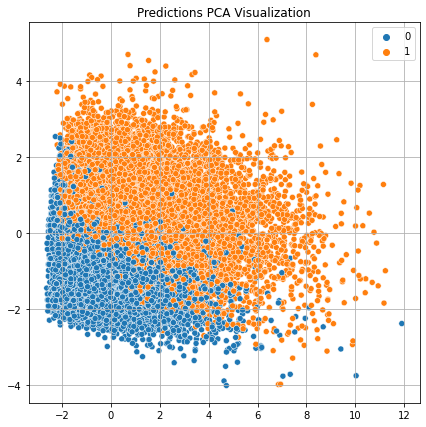

In [19]:
fig, ax = plot_pca(
    df_filtered[FEATURES],
    pipe.predict(df_filtered.loc[:, FEATURES]),
    interval=20,
    figsize=(7, 7)
)
ax.set_title("Predictions PCA Visualization")
fig.savefig("images/pca_logreg.png")
plt.show()

In [20]:
# joblib.dump(pipe, "ensambles baseline/assets/LogisticRegressionModel.pkl")

# Logistic Regression review
The classification problem seemed to fare a little better than the regressions, with an accuracy slightly better than
a random or constant output. It is also comforting to see that the confusion matrices have a dominant diagonal. We can also see that the original intuition from the PCA seemed to be correct as the logsitic regression accumulates 0-labeled points near the tip of the cone shape.

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're"]


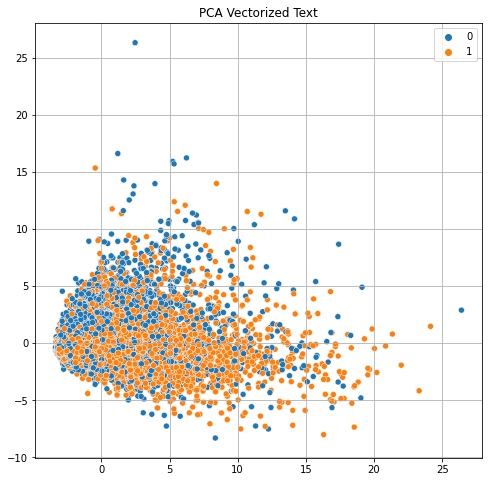

In [21]:
# Load stopwords. These do not include wh-words
with open("ensambles baseline/assets/stopwords.txt", "r") as f:
    stops = f.read().split("\n")
    print(stops[:10])


bodies = df_filtered["body"]
cv = CountVectorizer(min_df=0.025, max_features=600, stop_words=stops)
bodies_tf = cv.fit_transform(bodies)

fig, ax = plot_pca(
    bodies_tf.toarray(),
    df_filtered["target"].values,
    interval=35,
    figsize=(8, 8)
)

ax.set_title("PCA Vectorized Text")
plt.show()

# Vectorized Words PCA
The vectorized representation of the document bodies doesn't seem to segmentthe documents by label much better than the hand-made features, at least as far as we can see in PCA space. There are, however, some regions that appera to have a higher concentration of one class than the other.

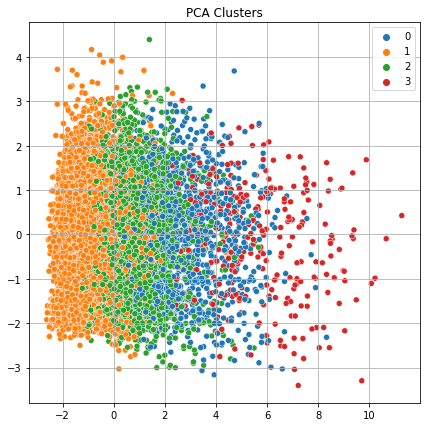

,target,id
cluster,,
1,0.533892,410658
2,0.619250,210789
0,0.676743,73768
3,0.721393,19156


In [22]:
km = MiniBatchKMeans(4, max_iter=200, batch_size=1024, random_state=456)
clusters = km.fit_predict(df_filtered[FEATURES])

df_clust = df_filtered.assign(cluster=clusters)
fig, ax = plot_pca(
    df_clust[FEATURES].values,
    df_clust["cluster"].astype("str").values,
    interval=64,
    figsize=(7, 7)
)
ax.set_title("PCA Clusters")
plt.show()

df_clust.groupby("cluster").agg({
    "target": "mean",
    "id": "count"
}).sort_values(by="target")